<a href="https://www.kaggle.com/code/klyushnik/rainfall-dataset-roc-auc-0-87127?scriptVersionId=227193856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv
/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv


# Description

![Rainfall.jpeg](https://www.naijanews.com/wp-content/uploads/2024/08/Rainfall.jpeg)

**My name is Alexander and I present to your attention my vision of the dataset, model selection and results. People have always wanted to predict rain and snowfalls with high probability, and now with advanced tools we can look ahead.**

**Today we will predict probabilities**

**Your Goal: Your goal is to predict rainfall for each day of the year.**

**Submissions are evaluated on area under the ROC curve**

![662c42679571ef35419c995f_647606906b8c519b822b9090_classification_metrics_011-min.png](https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c42679571ef35419c995f_647606906b8c519b822b9090_classification_metrics_011-min.png)

**Welcome to my github - https://github.com/Alexsandrrus/projekts-Kaggle**

# Libraries and useful programs

In [2]:
import os
import warnings

from scipy.optimize import minimize
from scipy.stats import mstats
from scipy import stats

import catboost
import lightgbm as lgb
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sklearn
from catboost import CatBoostClassifier
from catboost.utils import get_fnr_curve, get_fpr_curve, get_roc_curve
from ipywidgets import Image
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.feature_selection import (SelectKBest, RFECV, chi2, 
                                        VarianceThreshold, SequentialFeatureSelector)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             log_loss, roc_curve, roc_auc_score)
from sklearn.model_selection import (KFold, RepeatedKFold,
                                     RepeatedStratifiedKFold,
                                     StratifiedGroupKFold, StratifiedKFold,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, QuantileTransformer, StandardScaler,
                                   PowerTransformer, MaxAbsScaler, MinMaxScaler,
                                   RobustScaler, PolynomialFeatures, OrdinalEncoder, 
                                    OneHotEncoder,FunctionTransformer, KBinsDiscretizer)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from category_encoders import TargetEncoder, MEstimateEncoder

from imblearn.over_sampling import (SMOTE, ADASYN, 
                                    BorderlineSMOTE, RandomOverSampler,
                                    KMeansSMOTE)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline

import optuna
import logging

mpl.rcParams.update(mpl.rcParamsDefault)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        mean_value = df[feature].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        median_value = df[feature].median()
        axes[i].axvline(median_value, color='orange', linestyle='--', label='Median')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Theoretical Quantiles', fontsize=14)
        axes[i].set_ylabel('Sample Quantiles', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha= 0.7)  

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'k'}, height=2.5)
    plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold')
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i], palette='viridis', order=top_categories)
        else:
            sns.countplot(data=df, y=feature, ax=axes[i], palette='viridis')
        
        axes[i].set_title(f'Count of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='y', rotation=0)
        axes[i].grid(True, linestyle='--', alpha=0.7)  
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

# Import dataset

## Load

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
original = pd.read_csv('/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv')

train.shape, test.shape, original.shape

((2190, 13), (730, 12), (366, 12))

In [5]:
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

train.shape, test.shape

((2190, 12), (730, 11))

In [6]:
original.columns = original.columns.str.replace(' ', '')
original = original[original.columns].copy()
original['rainfall'] = original['rainfall'].map({'no': 0, 'yes': 1})
original['humidity']=original['humidity'].astype(float)
original['cloud']=original['cloud'].astype(float)
train_features=list(train)
original=original[train_features]
train = pd.concat([train, original], axis=0, ignore_index=True)

train.shape, test.shape

((2556, 12), (730, 11))

## Info

In [7]:
train.head()

day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
0    1    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1    2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2    3    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3    4    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4    5    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

   sunshine  winddirection  windspeed  rainfall  
0       1.1           60.0       17.2         1  
1       0.0           50.0       21.9         1  
2       8.3           70.0       18.1         1  
3       0.0           60.0       35.6         1  
4       3.6           40.0       24.8         0

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2556 non-null   int64  
 1   pressure       2556 non-null   float64
 2   maxtemp        2556 non-null   float64
 3   temparature    2556 non-null   float64
 4   mintemp        2556 non-null   float64
 5   dewpoint       2556 non-null   float64
 6   humidity       2556 non-null   float64
 7   cloud          2556 non-null   float64
 8   sunshine       2556 non-null   float64
 9   winddirection  2555 non-null   float64
 10  windspeed      2555 non-null   float64
 11  rainfall       2556 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 239.8 KB


In [9]:
duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

train = train.drop_duplicates()

Number of duplicates: 0


In [10]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

day - 0%
pressure - 0%
maxtemp - 0%
temparature - 0%
mintemp - 0%
dewpoint - 0%
humidity - 0%
cloud - 0%
sunshine - 0%
winddirection - 0%
windspeed - 0%
rainfall - 0%


In [11]:
train.describe().T

count         mean         std    min     25%     50%     75%  \
day            2556.0   156.437402  113.147285    1.0    44.0   148.0   255.0   
pressure       2556.0  1013.622261    5.769101  998.5  1008.6  1013.0  1017.8   
maxtemp        2556.0    26.340806    5.700976    7.1    21.3    27.8    31.2   
temparature    2556.0    23.923592    5.282473    4.9    19.3    25.5    28.4   
mintemp        2556.0    22.130634    5.138897    3.1    17.6    23.8    26.5   
dewpoint       2556.0    20.387911    5.396788   -0.4    16.8    22.1    25.0   
humidity       2556.0    81.770344    8.186720   36.0    77.0    81.0    87.0   
cloud          2556.0    75.064163   18.678173    0.0    68.0    83.0    88.0   
sunshine       2556.0     3.841080    3.678826    0.0     0.4     2.4     7.0   
winddirection  2555.0   104.383679   80.242979   10.0    40.0    70.0   200.0   
windspeed      2555.0    21.766458    9.921727    4.4    14.1    20.5    27.9   
rainfall       2556.0     0.742958    0.437088    0.0     0.0     1.0     1.0   

                  max  
day             365.0  
pressure       1034.6  
maxtemp          36.3  
temparature      32.4  
mintemp          30.0  
dewpoint         26.7  
humidity         98.0  
cloud           100.0  
sunshine         12.1  
winddirection   350.0  
windspeed        59.5  
rainfall          1.0

## Optimize memory

In [12]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

Memory usage size: before 0.2341 Mb - after 0.1049 Mb (55.2%).
Memory usage size: before 0.0614 Mb - after 0.0294 Mb (52.2%).


# EDA

## Time

In [13]:
print(train['day'].min(),',', train['day'].max())

1 , 365


## Hist plot

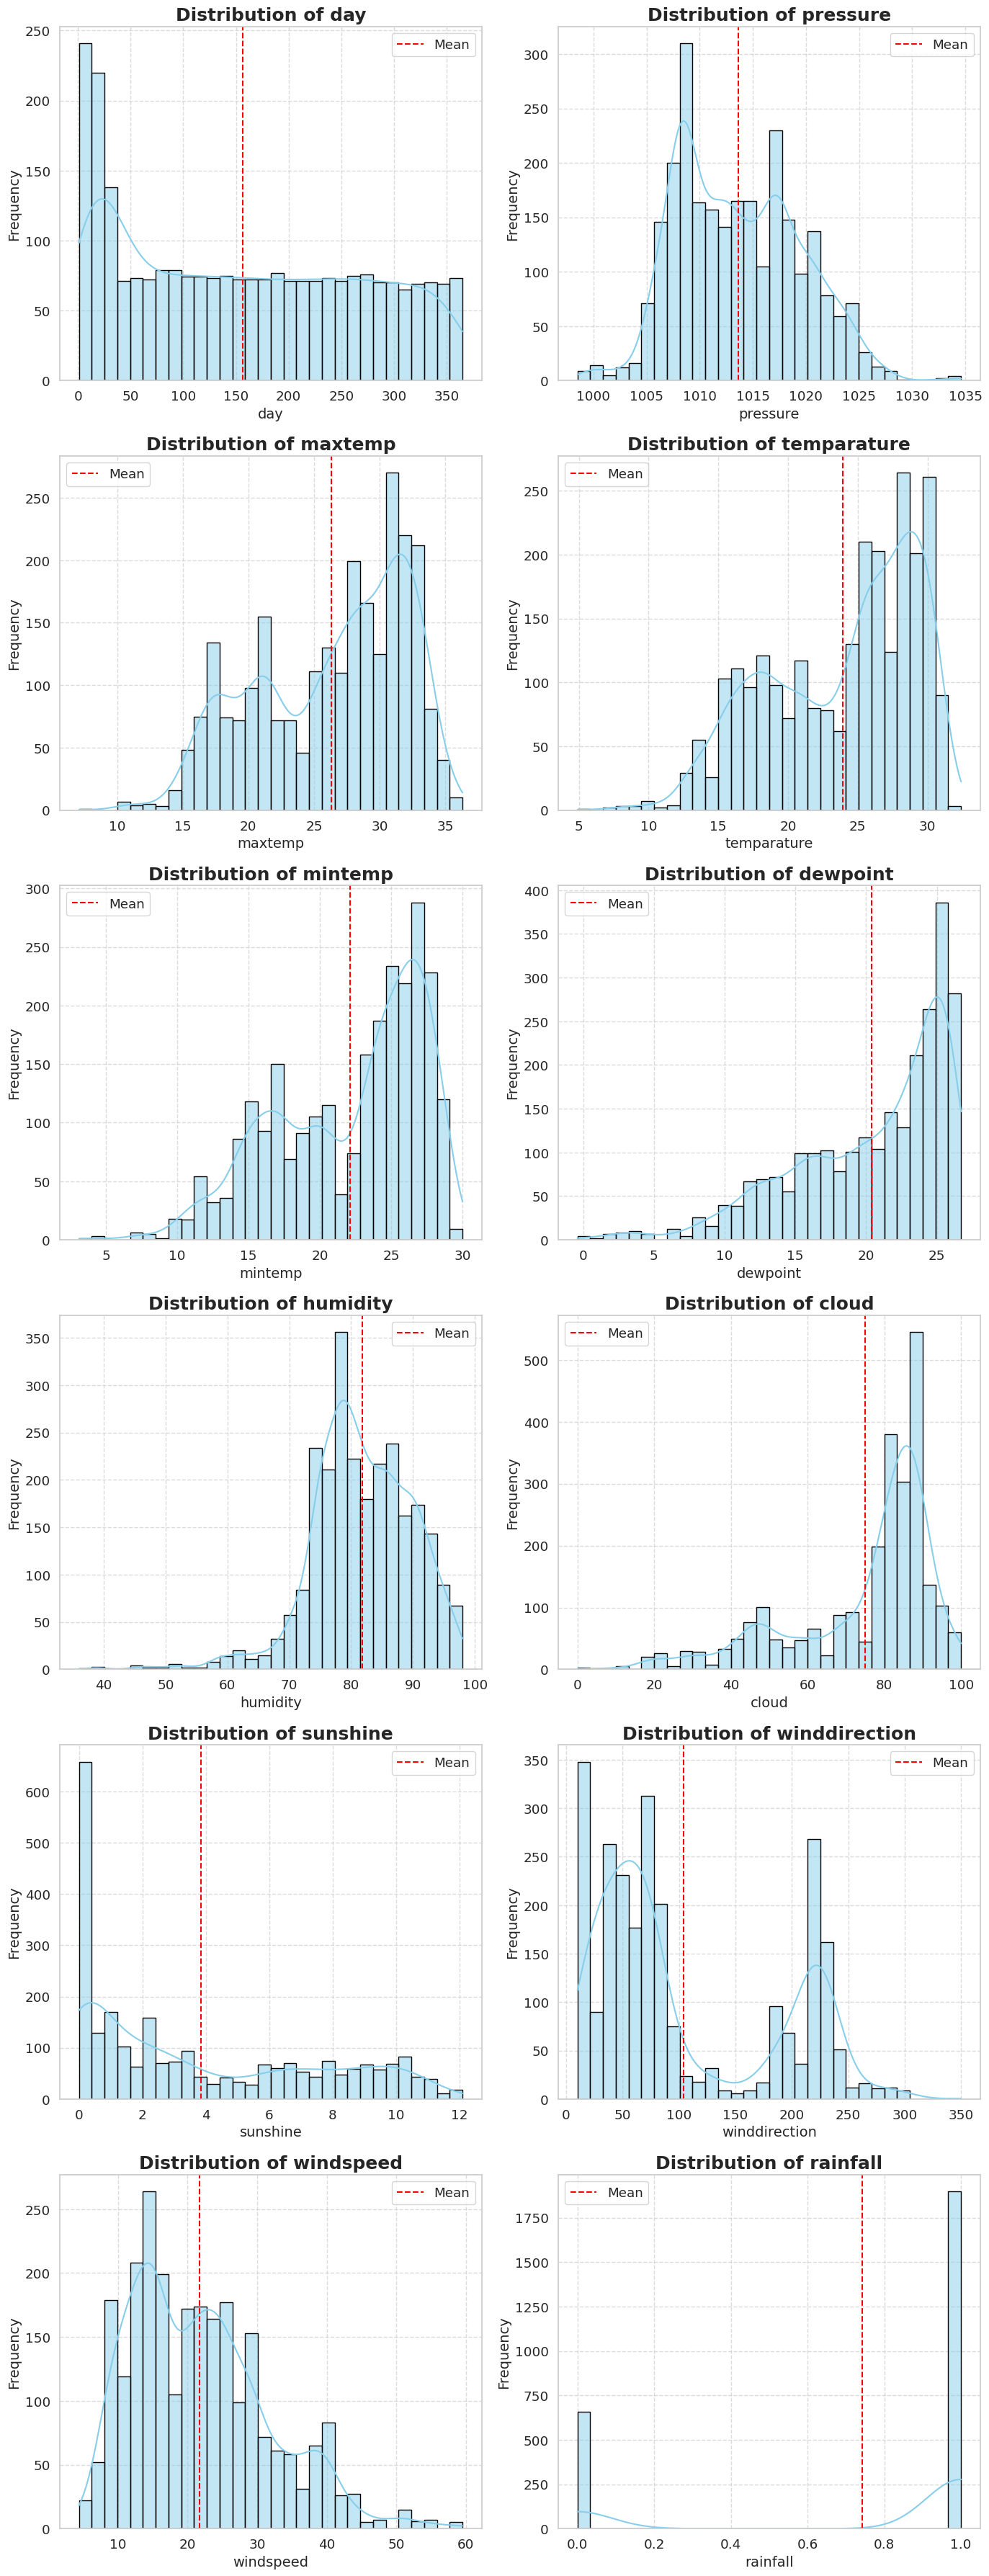

In [14]:
plot_numerical_features(train)

## Boxplot

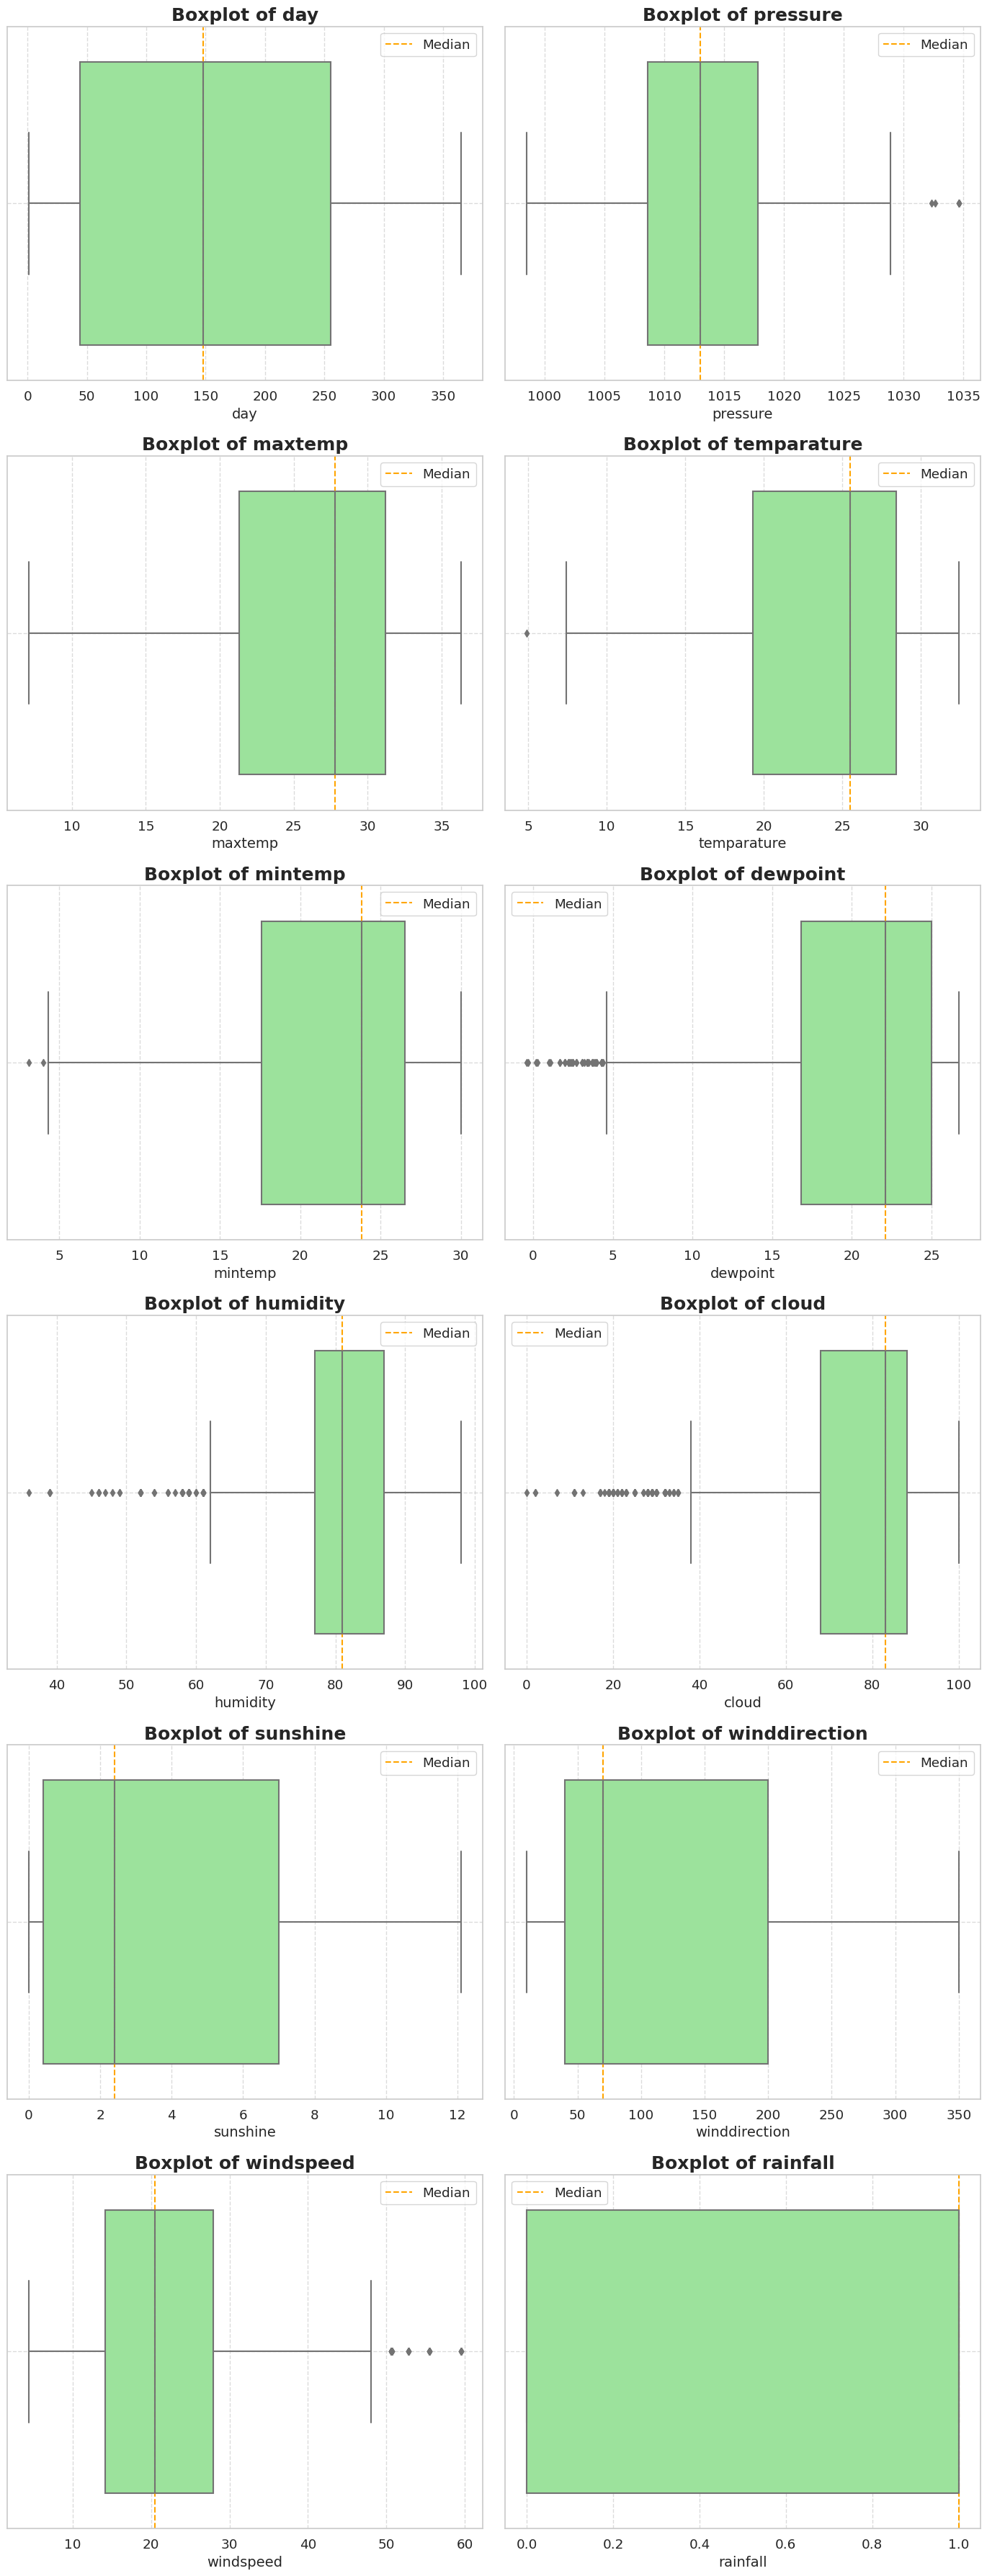

In [15]:
plot_numerical_boxplots(train)

## QQ plot

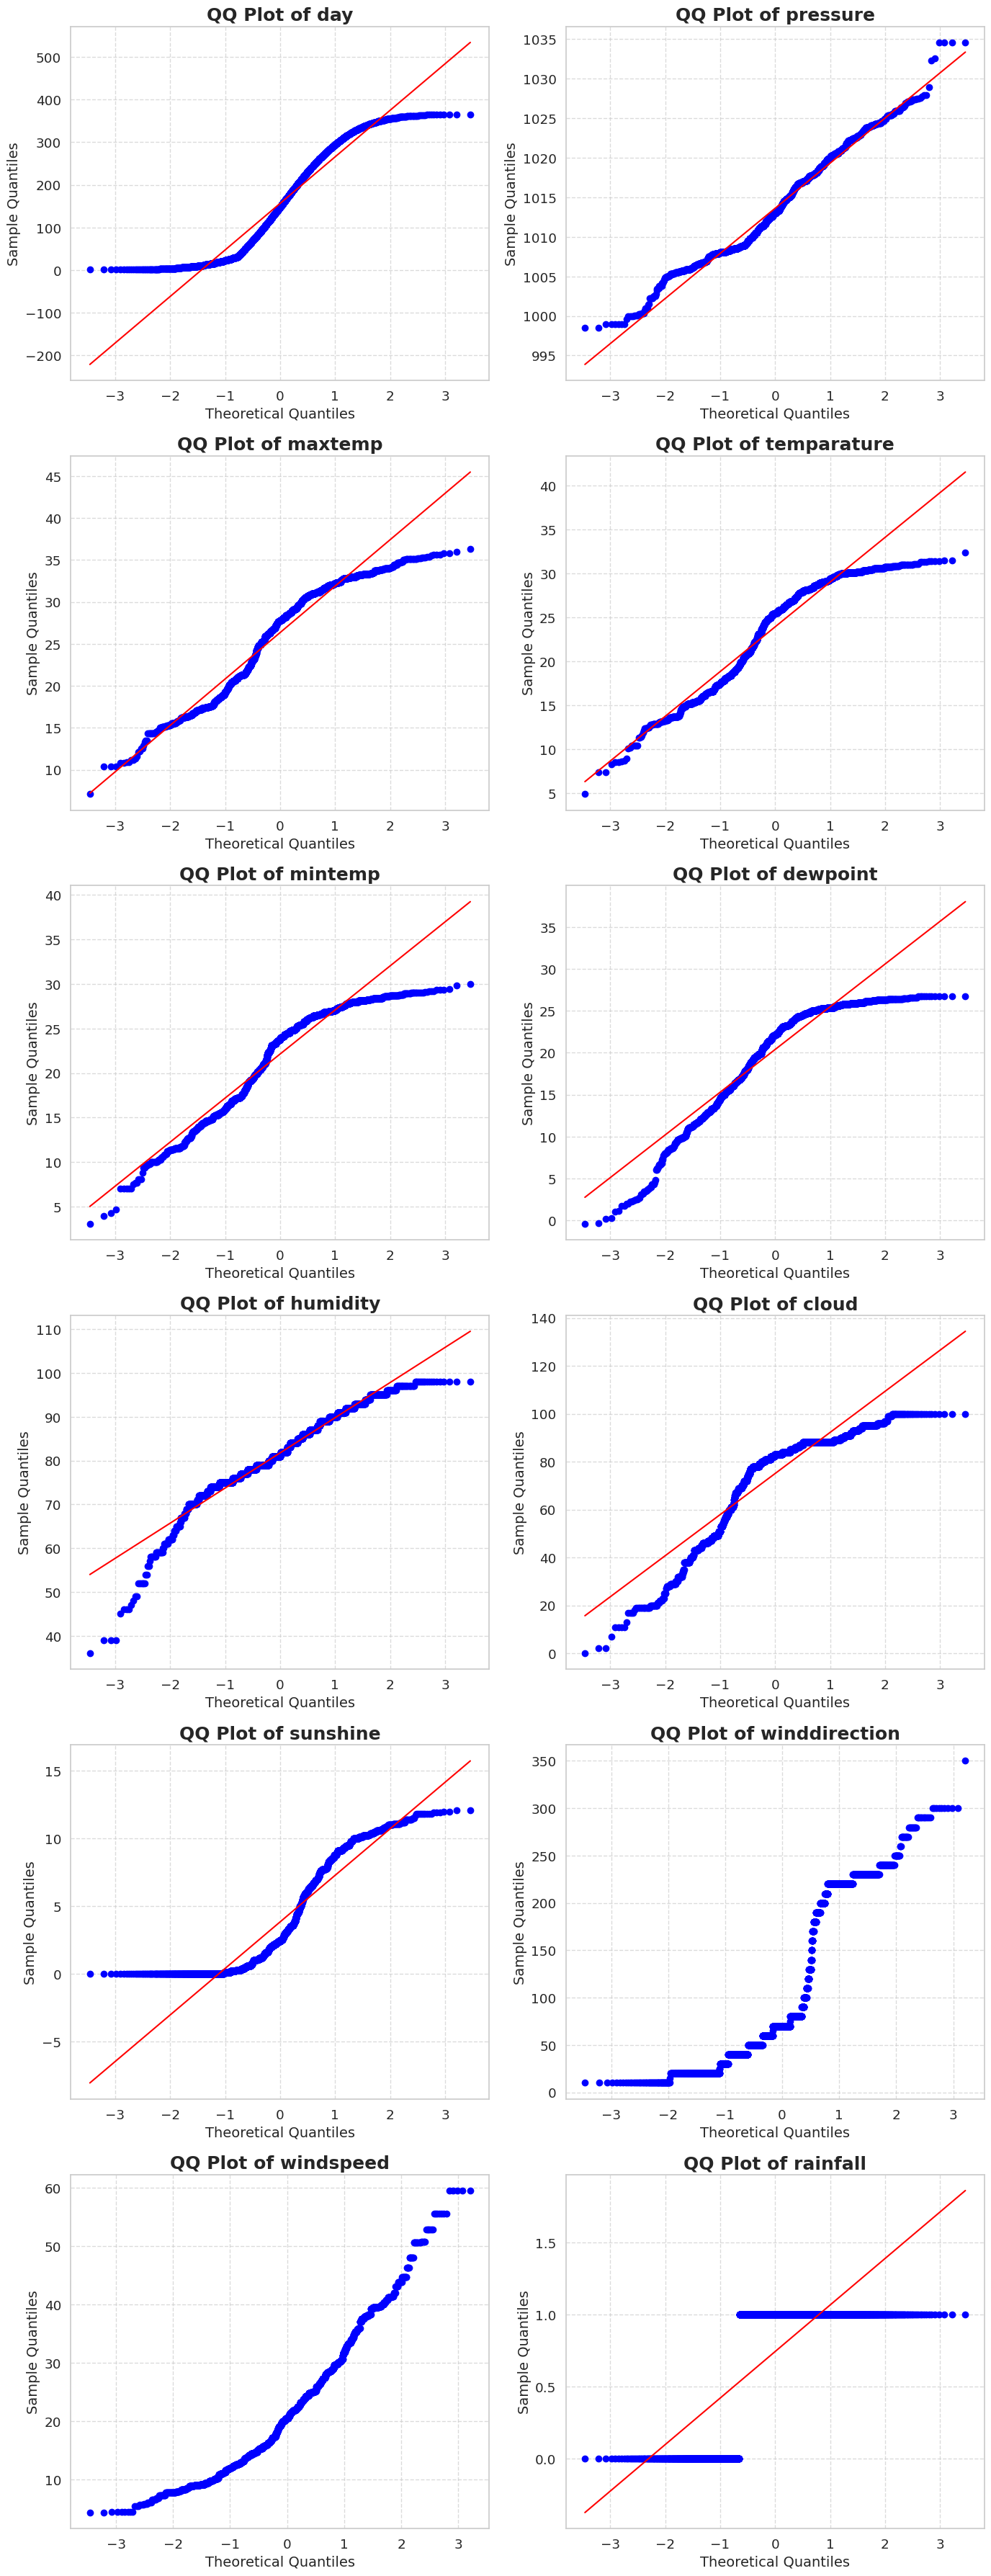

In [16]:
plot_qq_plot(train)

- **Data for the year 365 days**
- **There is an abnormally high pressure**
- **This is normal, we are just looking at some area with warm air**
- **Anomalies are present, but this is also normal. The weather varies**
- **Dew point depends on: Temperature; Relative air humidity. So it also changes depending on these parameters.**
- **Was there a drought this year?**
- **Was there a drought and no clouds? Logical!**
- **Moderate wind load**
- **There was a very strong wind this year, a hurricane or tornado, literally 4 - 5 times**

## Correlation matrix

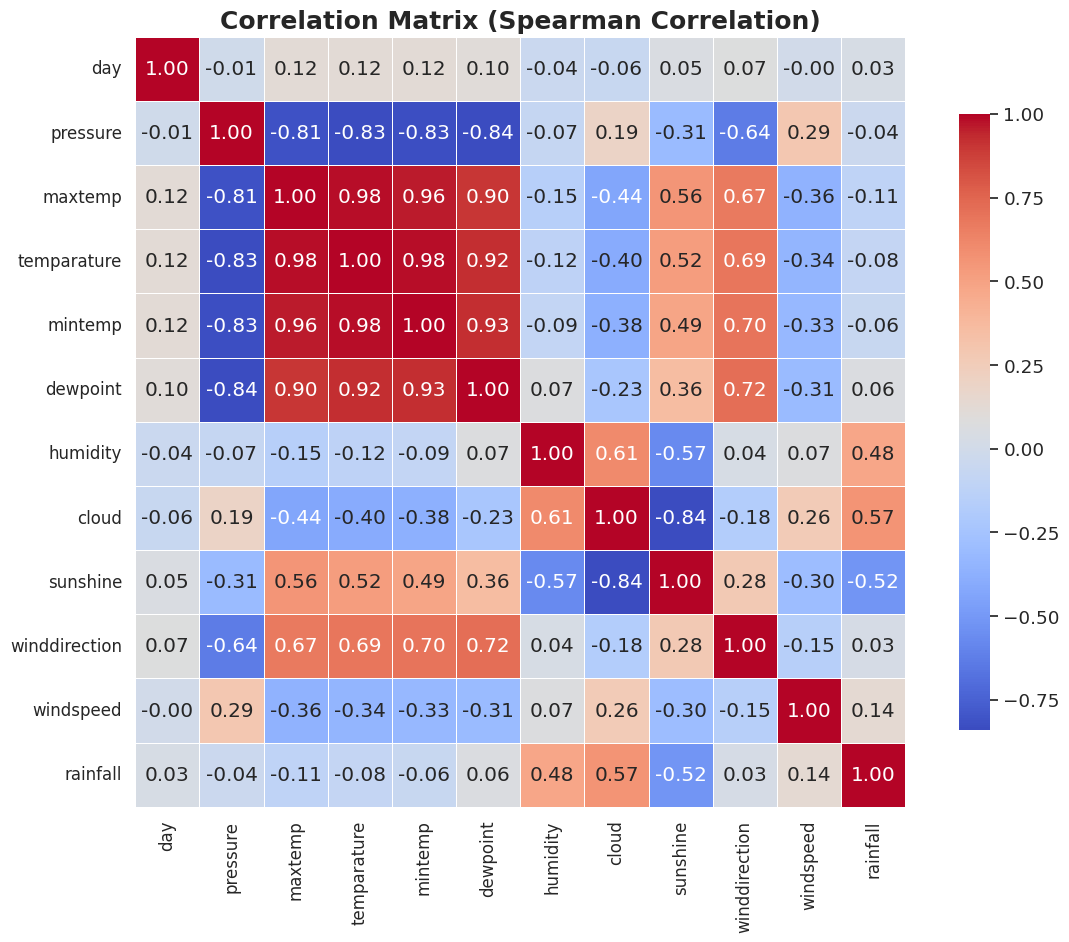

In [17]:
plot_correlation_matrix(train)

In [18]:
test['winddirection']=test['winddirection'].fillna(value=test['winddirection'].mean())
train['winddirection']=train['winddirection'].fillna(value=train['winddirection'].mean())
train['windspeed']=train['windspeed'].fillna(value=train['windspeed'].mean()) 

## VIF

In [19]:
X = sm.add_constant(train.select_dtypes(include=[np.number]).iloc [:, 1:])

VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

         Variable            VIF
0           const  117418.035472
1        pressure       3.610142
2         maxtemp      35.812747
3     temparature      93.873869
4         mintemp      47.874933
5        dewpoint      13.611654
6        humidity       2.102832
7           cloud       3.769327
8        sunshine       3.801890
9   winddirection       1.922192
10      windspeed       1.188902
11       rainfall       1.790883


**High values VIF tell us that one will interfere with the other and give a bad result**

In [20]:
test = test.drop(['maxtemp', 'mintemp'], axis =1)
train = train.drop(['maxtemp', 'mintemp'], axis =1)

train.shape, test.shape

((2556, 10), (730, 9))

## Pairplot

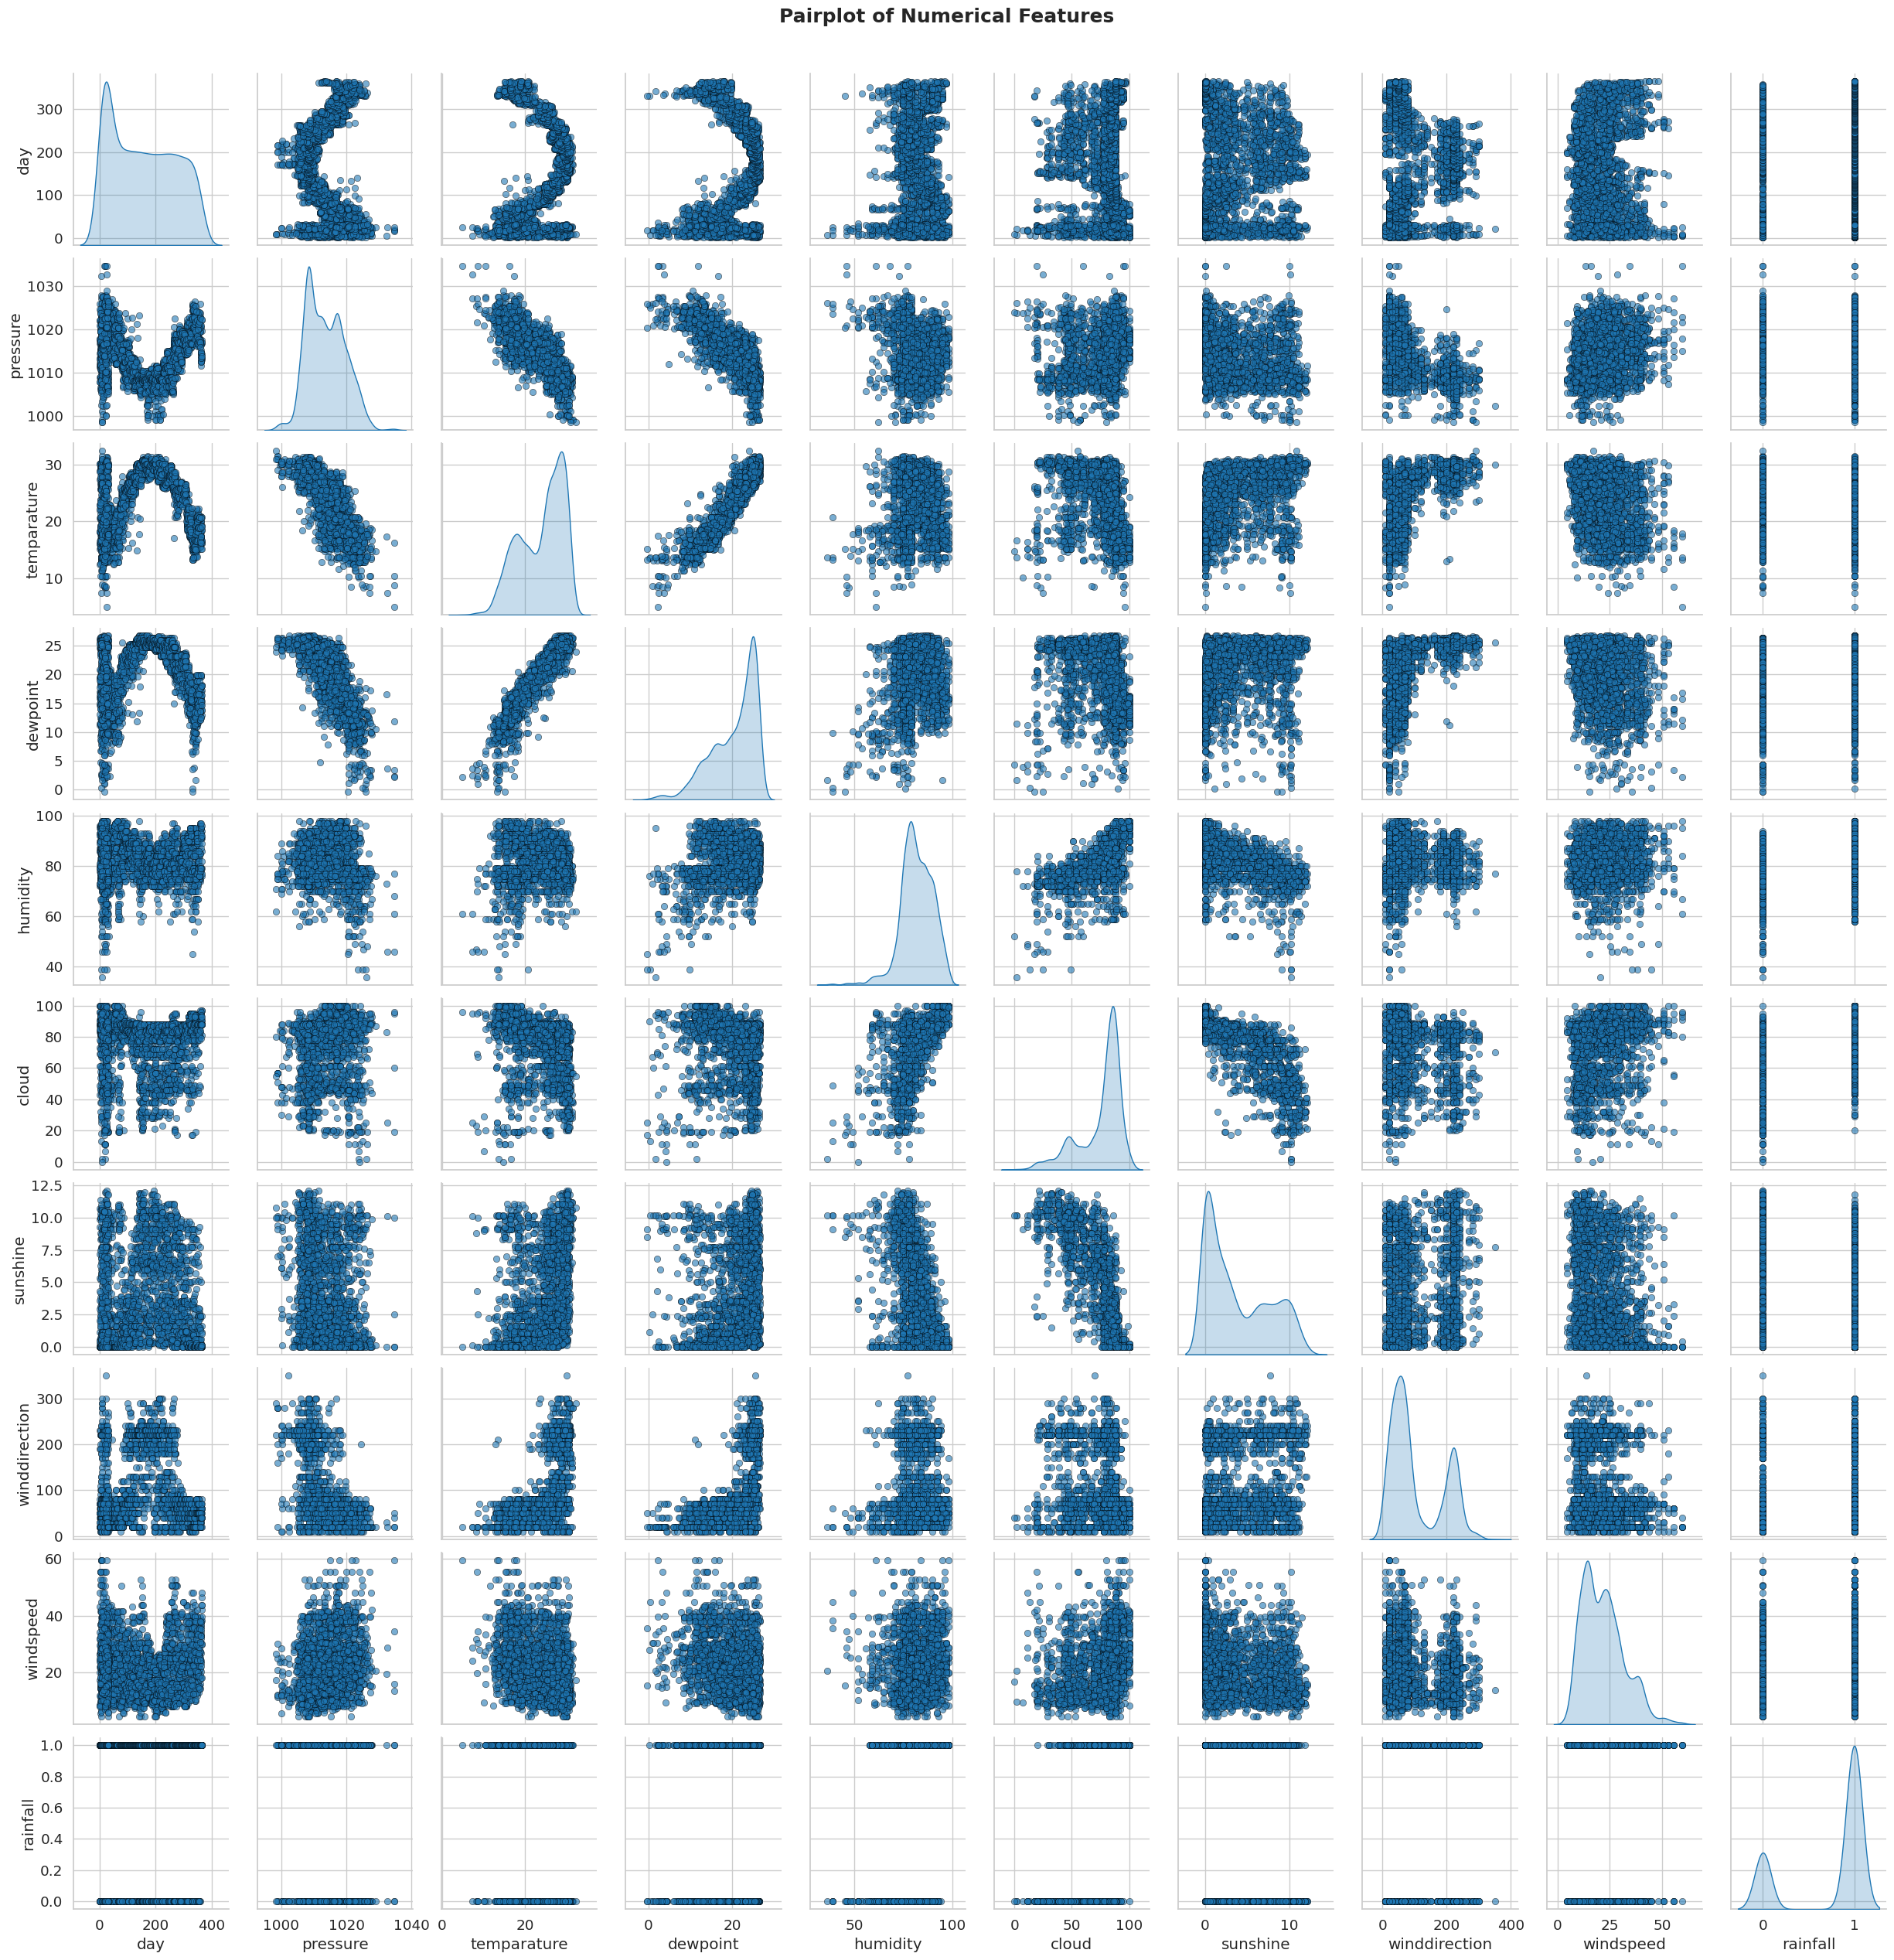

In [21]:
plot_pairplot(train)

## Balance target

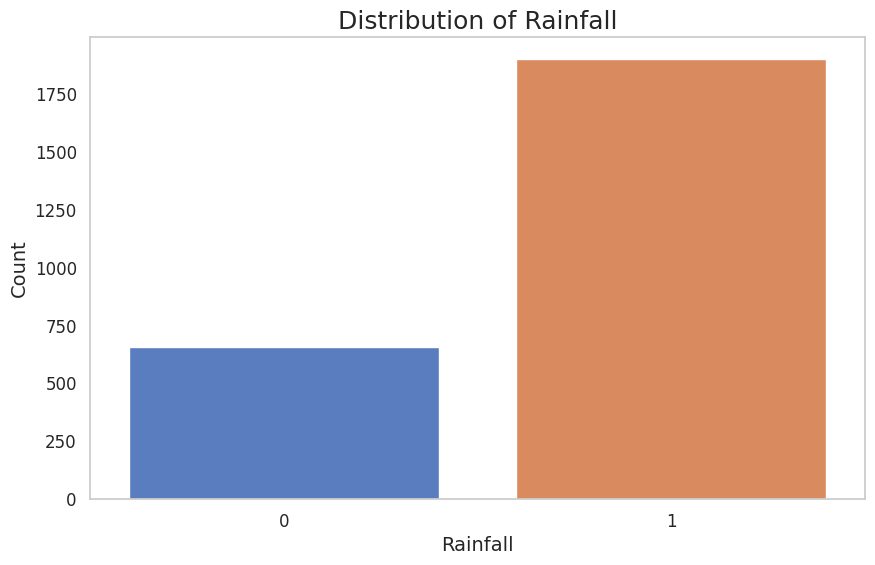

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rainfall', data=train, palette='muted')
plt.title('Distribution of Rainfall', fontsize=18)
plt.xlabel('Rainfall', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.show()

# Select new features

## Group data

In [23]:
def categorize_variable(df, column, labels):
    bins = [-float('inf')] + [df[column].quantile(0.25), df[column].quantile(0.75)] + [float('inf')]
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)

categorize_variable(train, 'pressure', ["low", "normal", 'high'])
categorize_variable(train, 'temparature', ["low", "normal", 'high'])
categorize_variable(train, 'dewpoint', ["low", "normal", 'high'])
categorize_variable(train, 'humidity', ["low", "normal", 'high'])
categorize_variable(train, 'cloud', ["low", "normal", 'high'])

categorize_variable(test, 'pressure', ["low", "normal", 'high'])
categorize_variable(test, 'temparature', ["low", "normal", 'high'])
categorize_variable(test, 'dewpoint', ["low", "normal", 'high'])
categorize_variable(test, 'humidity', ["low", "normal", 'high'])
categorize_variable(test, 'cloud', ["low", "normal", 'high'])

categorize_variable(train, 'sunshine', ['high', "normal","low"])
categorize_variable(test, 'sunshine',['high', "normal","low"])


categorize_variable(train, 'winddirection', ["low", "normal", 'high'])
categorize_variable(train, 'windspeed', ["low", "normal", 'high'])

categorize_variable(test, 'winddirection', ["low", "normal", 'high'])
categorize_variable(test, 'windspeed', ["low", "normal", 'high'])

train_shape = train.shape
test_shape = test.shape

train.shape, test.shape

((2556, 18), (730, 17))

# X, y transform

## Target Encode

In [24]:
col = ['pressure_group','temparature_group', 'dewpoint_group', 'humidity_group', 'cloud_group',
       'sunshine_group', 'winddirection_group', 'windspeed_group']
col_num = ['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud',
       'sunshine', 'winddirection', 'windspeed']

TE = MEstimateEncoder(cols=col, m=5.0)


train[col] = TE.fit_transform(train[col], train['rainfall'])
test[col] = TE.transform(test[col])

train.shape, test.shape

((2556, 18), (730, 17))

## Prepereing train, test

In [25]:
X = train.drop(columns=['rainfall'])
y = train['rainfall']
print('before threshold:',X.shape, y.shape)

X = variance_threshold(X,0.01)
list_name = (X.columns)
test = test[list_name]

print('after threshold:',X.shape, y.shape)

scaler = StandardScaler()

X[col_num] = scaler.fit_transform(X[col_num])
test[col_num] = scaler.transform(test[col_num])

oversample = make_pipeline(
    ADASYN(sampling_strategy='all', random_state=42, n_neighbors = 7),
    KMeansSMOTE(sampling_strategy='all', random_state=42, k_neighbors = 5),
    RandomOverSampler(random_state=42)               
)

X, y = oversample.fit_resample(X, y)

X.shape, y.shape, test.shape

before threshold: (2556, 17) (2556,)
after threshold: (2556, 12) (2556,)


((3952, 12), (3952,), (730, 12))

# Search parameters

## CatBoostClassifier

In [26]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 300, 1500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 14, step=1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10, step=1),
        'rsm': trial.suggest_float("rsm", 0.6, 0.9, step=0.1),
        'eval_metric': 'AUC',
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 2, 10, step=1),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 1, 10, step=1),
        'random_seed': 42, 
        'use_best_model': True
    }

    model = CatBoostClassifier(**param, early_stopping_rounds=300, verbose = 0)

    kf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = []

    for kfold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_test, y_test = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
        preds = model.predict_proba(X_test)[:, 1] 
        score = roc_auc_score(y_test, preds)  
        scores.append(score)

    return np.mean(scores)  

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50)

cat_param = study.best_params

print("Best parameters found: ", cat_param)

[I 2025-03-12 12:06:58,291] A new study created in memory with name: no-name-bcb42298-a702-40de-9ad9-99d7740e31d2
[I 2025-03-12 12:54:07,162] Trial 0 finished with value: 0.9622942418901399 and parameters: {'iterations': 1110, 'learning_rate': 0.01595157715863376, 'max_depth': 14, 'l2_leaf_reg': 3, 'rsm': 0.8, 'scale_pos_weight': 7, 'bagging_temperature': 4}. Best is trial 0 with value: 0.9622942418901399.
[I 2025-03-12 12:54:17,876] Trial 1 finished with value: 0.9157033012386322 and parameters: {'iterations': 990, 'learning_rate': 0.0016115202937210535, 'max_depth': 3, 'l2_leaf_reg': 10, 'rsm': 0.9, 'scale_pos_weight': 2, 'bagging_temperature': 6}. Best is trial 0 with value: 0.9622942418901399.
[I 2025-03-12 12:54:24,340] Trial 2 finished with value: 0.9459256497032495 and parameters: {'iterations': 570, 'learning_rate': 0.02781516302413653, 'max_depth': 3, 'l2_leaf_reg': 6, 'rsm': 0.8, 'scale_pos_weight': 5, 'bagging_temperature': 6}. Best is trial 0 with value: 0.9622942418901399.

Best parameters found:  {'iterations': 1200, 'learning_rate': 0.016364728138657705, 'max_depth': 14, 'l2_leaf_reg': 1, 'rsm': 0.6, 'scale_pos_weight': 5, 'bagging_temperature': 1}


## XGBClassifier

In [27]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500, step=10),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 14, step=1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),  
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 2, 10, step=1),
        'random_state': 42,  
        'use_label_encoder': False,  
        'eval_metric': 'auc'  
    }

    model = xgb.XGBClassifier(**param, early_stopping_rounds=300)

    kf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = []

    for kfold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_test, y_test = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        preds = model.predict_proba(X_test)[:, 1] 
        score = roc_auc_score(y_test, preds)  
        scores.append(score)

    return np.mean(scores)  


study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50) 

xgb_param = study.best_params

print("Best parameters found: ", xgb_param)

[I 2025-03-12 18:32:54,107] A new study created in memory with name: no-name-68a0334b-0947-4dbb-8adf-8289f6b418cf
[I 2025-03-12 18:33:01,436] Trial 0 finished with value: 0.929866242945397 and parameters: {'n_estimators': 460, 'learning_rate': 0.0012955248594639208, 'max_depth': 8, 'reg_alpha': 1.6994601015534438, 'reg_lambda': 8.380038591994087, 'subsample': 0.8, 'scale_pos_weight': 7}. Best is trial 0 with value: 0.929866242945397.
[I 2025-03-12 18:33:03,225] Trial 1 finished with value: 0.9435776415007308 and parameters: {'n_estimators': 460, 'learning_rate': 0.025340721059735838, 'max_depth': 2, 'reg_alpha': 9.253011251410259, 'reg_lambda': 4.509304013490484, 'subsample': 0.7, 'scale_pos_weight': 9}. Best is trial 1 with value: 0.9435776415007308.
[I 2025-03-12 18:33:25,875] Trial 2 finished with value: 0.9548188632034169 and parameters: {'n_estimators': 1090, 'learning_rate': 0.00545248304393921, 'max_depth': 13, 'reg_alpha': 4.782669625157917, 'reg_lambda': 1.2369344007665983, 's

Best parameters found:  {'n_estimators': 830, 'learning_rate': 0.03521184051497671, 'max_depth': 14, 'reg_alpha': 0.5529753407453561, 'reg_lambda': 4.552270900747757, 'subsample': 0.6, 'scale_pos_weight': 3}


## LGBMClassifier

In [28]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500, step=10),  
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 14, step=1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),  
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 2, 10, step=1),
        'random_state': 42,  
        'metric': 'auc'  
    }

    model = lgb.LGBMClassifier(**param, early_stopping_rounds=300, verbose=-1)

    kf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = []

    for kfold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_test, y_test = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        preds = model.predict_proba(X_test)[:, 1] 
        score = roc_auc_score(y_test, preds)  
        scores.append(score)

    return np.mean(scores)  

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50)  

lgb_param = study.best_params

print("Best parameters found: ", lgb_param)

[I 2025-03-12 18:40:14,653] A new study created in memory with name: no-name-498be9d1-1238-47da-afdb-8f87fcf5de26
[I 2025-03-12 18:40:20,016] Trial 0 finished with value: 0.9501805978386655 and parameters: {'n_estimators': 640, 'learning_rate': 0.010489905886205927, 'max_depth': 13, 'reg_alpha': 6.802753806229695, 'reg_lambda': 8.790018044897455, 'subsample': 0.9, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.9501805978386655.
[I 2025-03-12 18:40:22,815] Trial 1 finished with value: 0.9563422140002815 and parameters: {'n_estimators': 1490, 'learning_rate': 0.05515411767707577, 'max_depth': 8, 'reg_alpha': 5.9776957067612155, 'reg_lambda': 3.721097632103132, 'subsample': 0.9, 'scale_pos_weight': 7}. Best is trial 1 with value: 0.9563422140002815.
[I 2025-03-12 18:40:24,387] Trial 2 finished with value: 0.9565866613580122 and parameters: {'n_estimators': 920, 'learning_rate': 0.12768501162187137, 'max_depth': 8, 'reg_alpha': 6.215578882728872, 'reg_lambda': 9.27123428083871, 'sub

Best parameters found:  {'n_estimators': 1410, 'learning_rate': 0.17791244026076258, 'max_depth': 8, 'reg_alpha': 0.33067716329881736, 'reg_lambda': 3.3744639449057345, 'subsample': 0.6, 'scale_pos_weight': 9}


# Model

## Fit and predict

In [29]:
cat_param_0 = {'iterations': 850, 'learning_rate': 0.06855921972663766, 
               'max_depth': 10, 'l2_leaf_reg': 2, 'rsm': 0.9, 'scale_pos_weight': 6,
               'bagging_temperature': 4}

xgb_param_0 = {'n_estimators': 800, 'learning_rate': 0.02527247055514004, 
               'max_depth': 10, 'reg_alpha': 0.2742098809904236, 'reg_lambda': 3.598411400930554,
               'subsample': 0.8, 'scale_pos_weight': 6}

lgb_param_0 = {'n_estimators': 800, 'learning_rate': 0.07045054161803449, 'max_depth': 10,
                'reg_alpha': 0.9680103836311771, 'reg_lambda': 3.0421717564326567, 'subsample': 0.6,
                'scale_pos_weight': 9}

In [30]:
folds = 5
shuffle=True

predictions_cat, oof_cat = np.zeros(len(test)), np.zeros(len(X))
predictions_xgb, oof_xgb = np.zeros(len(test)), np.zeros(len(X))
predictions_lgbm, oof_lgbm = np.zeros(len(test)), np.zeros(len(X))
predictions_cat_0, oof_cat_0 = np.zeros(len(test)), np.zeros(len(X))
predictions_xgb_0, oof_xgb_0 = np.zeros(len(test)), np.zeros(len(X))
predictions_lgbm_0, oof_lgbm_0 = np.zeros(len(test)), np.zeros(len(X))
predictions_clf_1, oof_clf_1 = np.zeros(len(test)), np.zeros(len(X))



kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)

for kfold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model_cat = CatBoostClassifier(**cat_param, verbose=0)
    model_cat.fit(X_train, y_train,
                  eval_set=(X_val, y_val), plot=False)
    
    oof_cat[val_idx] = model_cat.predict_proba(X_val)[:, 1] / folds
    predictions_cat += model_cat.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_cat)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC CatBoostClassifier: {roc_auc:.4f}')

    model_xgb = xgb.XGBClassifier(**xgb_param)
    model_xgb.fit(X_train, y_train)
    
    oof_xgb[val_idx] = model_xgb.predict_proba(X_val)[:, 1] / folds
    predictions_xgb += model_xgb.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_xgb)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC XGBClassifier: {roc_auc:.4f}')

    model_lgbm = lgb.LGBMClassifier(**lgb_param, verbose = -1)
    model_lgbm.fit(X_train, y_train)
    
    oof_lgbm[val_idx] = model_lgbm.predict_proba(X_val)[:, 1] / folds
    predictions_lgbm += model_lgbm.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_lgbm)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC LGBMClassifier: {roc_auc:.4f}')

    model_cat_0 = CatBoostClassifier(**cat_param_0, verbose=0)
    model_cat_0.fit(X_train, y_train,
                  eval_set=(X_val, y_val), plot=False)
    
    oof_cat_0[val_idx] = model_cat_0.predict_proba(X_val)[:, 1] / folds
    predictions_cat_0 += model_cat_0.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_cat_0)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC CatBoostClassifier_0: {roc_auc:.4f}')

    model_xgb_0 = xgb.XGBClassifier(**xgb_param_0)
    model_xgb_0.fit(X_train, y_train)
    
    oof_xgb_0[val_idx] = model_xgb_0.predict_proba(X_val)[:, 1] / folds
    predictions_xgb_0 += model_xgb_0.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_xgb_0)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC XGBClassifier_0: {roc_auc:.4f}')

    model_lgbm_0 = lgb.LGBMClassifier(**lgb_param_0, verbose = -1)
    model_lgbm_0.fit(X_train, y_train)
    
    oof_lgbm_0[val_idx] = model_lgbm_0.predict_proba(X_val)[:, 1] / folds
    predictions_lgbm_0 += model_lgbm_0.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_lgbm_0)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC LGBMClassifier_0: {roc_auc:.4f}')

    model_knn = KNeighborsClassifier(n_neighbors =7)
    model_knn.fit(X_train, y_train)
    
    oof_clf_1[val_idx] = model_knn.predict_proba(X_val)[:, 1] / folds
    predictions_clf_1 += model_knn.predict_proba(test)[:, 1] / folds  
    
    roc_auc = roc_auc_score(y, oof_clf_1)
    
    print(f'Fold {kfold + 1}/{folds}, ROC AUC KNeighborsClassifier: {roc_auc:.4f}')

Fold 1/5, ROC AUC CatBoostClassifier: 0.5184
Fold 1/5, ROC AUC XGBClassifier: 0.5187
Fold 1/5, ROC AUC LGBMClassifier: 0.5187
Fold 1/5, ROC AUC CatBoostClassifier_0: 0.5182
Fold 1/5, ROC AUC XGBClassifier_0: 0.5188
Fold 1/5, ROC AUC LGBMClassifier_0: 0.5187
Fold 1/5, ROC AUC KNeighborsClassifier: 0.5421
Fold 2/5, ROC AUC CatBoostClassifier: 0.5731
Fold 2/5, ROC AUC XGBClassifier: 0.5742
Fold 2/5, ROC AUC LGBMClassifier: 0.5738
Fold 2/5, ROC AUC CatBoostClassifier_0: 0.5725
Fold 2/5, ROC AUC XGBClassifier_0: 0.5744
Fold 2/5, ROC AUC LGBMClassifier_0: 0.5739
Fold 2/5, ROC AUC KNeighborsClassifier: 0.6025
Fold 3/5, ROC AUC CatBoostClassifier: 0.6658
Fold 3/5, ROC AUC XGBClassifier: 0.6670
Fold 3/5, ROC AUC LGBMClassifier: 0.6662
Fold 3/5, ROC AUC CatBoostClassifier_0: 0.6640
Fold 3/5, ROC AUC XGBClassifier_0: 0.6672
Fold 3/5, ROC AUC LGBMClassifier_0: 0.6663
Fold 3/5, ROC AUC KNeighborsClassifier: 0.6809
Fold 4/5, ROC AUC CatBoostClassifier: 0.7923
Fold 4/5, ROC AUC XGBClassifier: 0.7947


## Plot

In [31]:
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'Receiver Operating Characteristic (ROC) Curve {model_name}', fontsize=16)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

### CatBoostClassifier

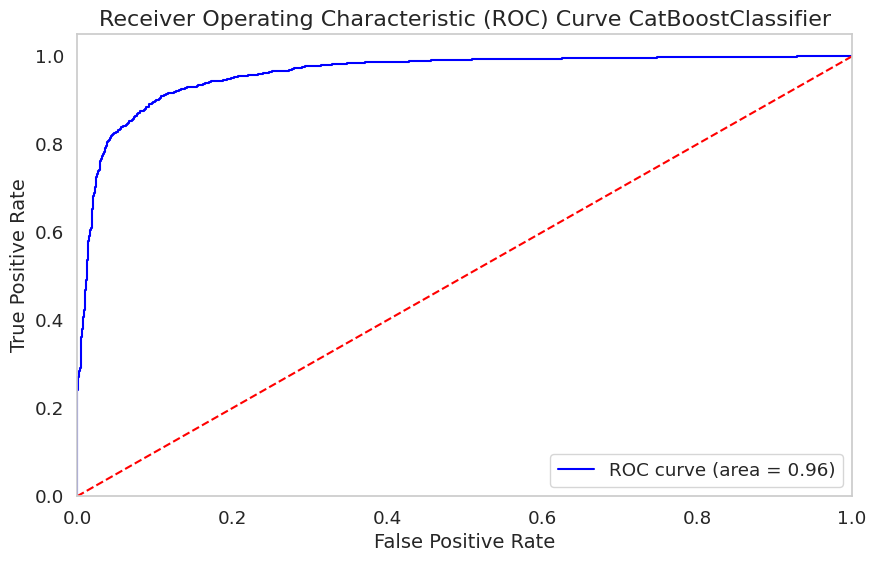

In [32]:
plot_roc_curve(y, oof_cat, 'CatBoostClassifier')

### XGBClassifier

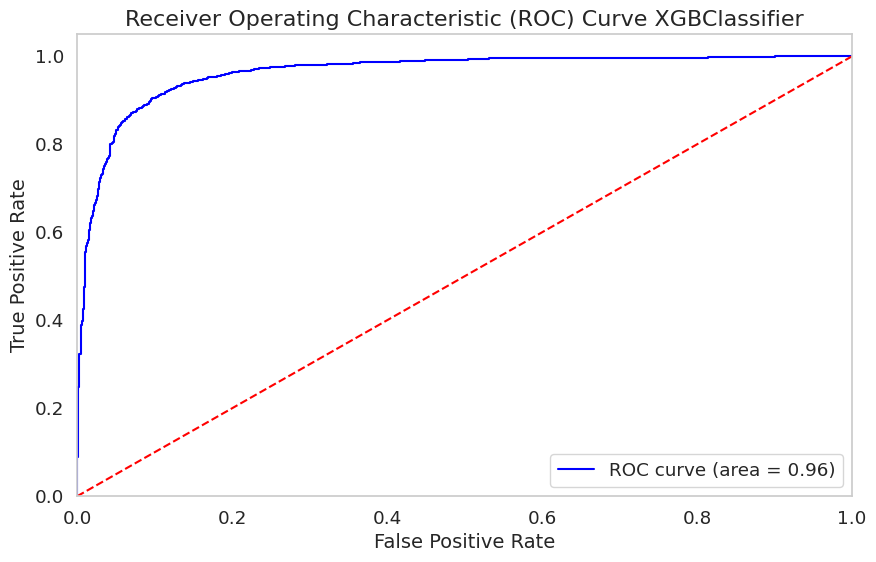

In [33]:
plot_roc_curve(y, oof_xgb, 'XGBClassifier')

### LGBMClassifier

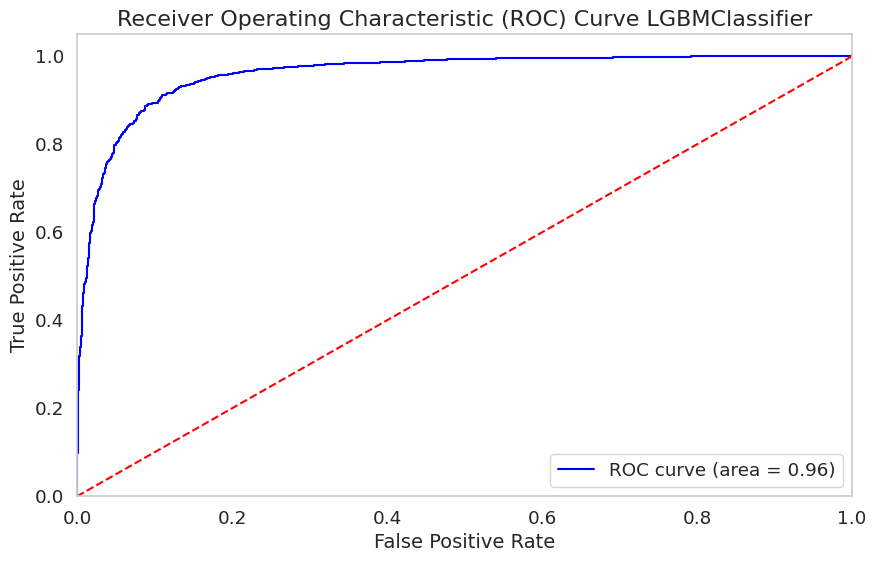

In [34]:
plot_roc_curve(y, oof_lgbm, 'LGBMClassifier')

## Blend

In [35]:
blend_df = pd.DataFrame({'1': oof_cat,
                         '2': oof_xgb,
                         '3': oof_lgbm,
                         '4': oof_cat_0,
                         '5': oof_xgb_0,
                         '6': oof_lgbm_0,
                         '7': oof_clf_1,
                         })

blend_test_df = pd.DataFrame({  '1': predictions_cat,  
                                '2': predictions_xgb, 
                                '3': predictions_lgbm, 
                                '4': predictions_cat_0,  
                                '5': predictions_xgb_0, 
                                '6': predictions_lgbm_0, 
                                '7': predictions_clf_1
                        })

def calculate_roc_auc(weights, blend_df, y_):
    weighted_predictions = np.dot(blend_df, weights)
    return -roc_auc_score(y_, weighted_predictions)  
    
def constraint(weights):
    return np.sum(weights) - 1 

initial_weights = np.array([0.2] * blend_df.shape[1])  

constraints = {'type': 'eq', 'fun': constraint}
bounds = [(0, 1) for _ in range(blend_df.shape[1])]  

result = minimize(calculate_roc_auc, initial_weights, args=(blend_df, y), 
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
optimal_roc_auc = -result.fun  

print(f"Optimal weights: {optimal_weights}")
print(f"Best ROC AUC: {optimal_roc_auc:.4f}")

Optimal weights: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
Best ROC AUC: 0.9659


In [36]:
# def objective(trial):
#     weights = [trial.suggest_float(f'weight_{i}', 0, 1) for i in range(blend_df.shape[1])]
    
#     weights = np.array(weights)
#     weights /= np.sum(weights)  

#     weighted_predictions = np.dot(blend_df, weights)
    
#     return -roc_auc_score(y, weighted_predictions)

# study = optuna.create_study(direction='maximize') 
# study.optimize(objective, n_trials=1)  

# optimal_weights = [study.best_params[f'weight_{i}'] for i in range(blend_df.shape[1])]
# optimal_roc_auc = -study.best_value  

# print(f"Optimal weights: {optimal_weights}")
# print(f"Best ROC AUC: {optimal_roc_auc:.4f}")

# Submit

In [37]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')
sample['rainfall'] = np.dot(blend_test_df, optimal_weights)
sample.to_csv('submission.csv', index=False)

In [38]:
sample.head()

id  rainfall
0  2190  0.998936
1  2191  0.999367
2  2192  0.993210
3  2193  0.055207
4  2194  0.025273

**Thank you!**